# EPI Analysis Code Part 1:
1) Reads in HRRR Data
2) Makes a cross section along a flight track
3) Calculated equivalent potential temperature wrt ice and water
4) Saves cross sections to be read in for part 2

# Read in Packages

In [1]:
import fsspec
import h5py
import xarray as xr

import netCDF4
from netCDF4 import Dataset

import metpy.calc as mpcalc
from metpy.interpolate import cross_section, interpolate_to_slice
from metpy.units import units
from metpy.plots import USCOUNTIES

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

import icartt

import glob

import math as mt

from datetime import datetime, timedelta

# Define Paramters:
- day: choosen IOP ['YYYYMMDD']
- Region: region to map over ['MW' (midwest)  or 'NE' (northeast)]
- fl_choice: aircraft you want to interpoate HRRR to ['P3' or 'ER2']
- fcst_lead: how many hours prior the model was started... kept at 0 since using initialization data
- path: file path for where your data is

In [2]:
day='20200125'

region='NE'

ymin=0
ymax=12

fl_choice='ER2'

fcst_lead = 0

path=''

# Defining Functions

## Setting Variable Definitions

In [3]:
if region=='NE':
    lats=33
    latn=48
    lonw=360-82
    lone=360-68
    
if region=='MW':
    lats=39
    latn=47
    lonw=360-96
    lone=360-84

plotcrs = ccrs.LambertConformal(central_latitude=lats+((latn-lats)/2), central_longitude=lone-((276-264)/2))

In [4]:
if day=='jan182020':
    startT_p3='2020-01-18 18:02:00'
    endT_p3='2020-01-19 00:02:00'
    
    startT_er2='2020-01-18 17:15:00'
    endT_er2='2020-01-18 21:06:00'
    
    date='2020-01-18'
    
    title=str('January 18, 2020')
    
if day=='jan252020':
    startT_er2='2020-01-25 17:49:00'
    endT_er2='2020-01-26 01:25:00'
    
    date='2020-01-25'
    
if day=='feb012020':
    startT_er2='2020-02-01 11:09:00'
    endT_er2='2020-02-01 17:07:00'
    
    date='2020-02-01'
    
if day=='feb052020':
    startT_er2='2020-02-05 18:59:00'
    endT_er2='2020-02-06 01:34:00'
    
    date='2020-02-05'
    
if day=='feb072020':
    startT_er2='2020-02-071, 12:04:00'
    endT_er2='2020-02-07 18:51:00'
    
    date='2020-02-07'

if day=='feb252020':
    startT_er2='2020-02-25 20:06:00'
    endT_er2='2020-02-26 03:56:00'
    
    date='2020-02-25'
    
if day=='feb272020':
    startT_er2='2020-02-27 07:21:00'
    endT_er2='2020-02-27 15:16:00'
    
    date='2020-02-27'

if day=='jan192022':
    startT_er2='2022-01-19 10:46:00'
    endT_er2='2022-01-19 17:57:00'
    
    date='2022-01-19'
    
if day=='jan292022':
    startT_er2='2022-01-29 22:17:00'
    endT_er2='2022-01-30 03:47:00'
    
    date='2022-01-29'
    
if day=='feb032022':
    startT_er2='2022-02-03 13:53:00'
    endT_er2='2022-02-03 17:05:00'
    
    date='2022-02-03'
    
if day=='feb042022':
    startT_er2='2022-02-04 12:29:00'
    endT_er2='2022-02-04 20:30:00'
    
    date='2022-02-04'
    
if day=='feb082022':
    startT_er2='2022-02-08 11:59:00'
    endT_er2='2022-02-08 19:17:00'
    
    date='2022-02-08'
    
if day=='feb132022':
    startT_er2='2022-02-13 11:29:00'
    endT_er2='2022-02-13 16:24:00'
    
    date='2022-02-13'
    
if day=='feb172022':
    startT_er2='2022-02-17 16:07:00'
    endT_er2='2022-02-17 00:27:00'
    
    date='2022-02-17'

if day=='feb192022':
    startT_p3='2022-02-19 12:12:00'
    endT_p3='2022-02-19 19:18:00'
    
    startT_er2='2022-02-19 12:07:00'
    endT_er2='2022-02-19 17:30:00'
    
    date='2022-02-19'
    
if day=='feb252022':
    startT_er2='2022-02-25 07:58:00'
    endT_er2='2022-02-25 15:34:00'
    
    date='2022-02-25'
    
if day=='jan132023':
    startT_er2='2023-01-13 03:55:00'
    endT_er2='2023-01-13 11:22:00'
    
    date='2023-01-13'
    
if day=='jan152023':
    startT_er2='2023-01-15 13:09:00'
    endT_er2='2023-01-15 20:26:00'
    
    date='2023-01-15'
    
if day=='jan192023':
    startT_er2='2023-01-19 19:58:00'
    endT_er2='2023-01-20 03:47:00'
    
    date='2023-01-19'
    
if day=='jan232023':
    startT_er2='2023-01-23 12:21:00'
    endT_er2='2023-01-23 19:42:00'
    
    date='2023-01-23'
    
if day=='jan252023':
    startT_er2='2023-01-25 17:52:00'
    endT_er2='2023-01-26 01:56:00'
    
    date='2023-01-25'
    
if day=='jan292023':
    startT_er2='2023-01-29 12:57:00'
    endT_er2='2023-01-29 19:02:00'
    
    date='2023-01-29'
    
if day=='feb052023':
    startT_er2='2023-02-05 13:00:00'
    endT_er2='2023-02-05 20:41:00'
    
    date='2023-02-05'

if day=='feb122023':
    startT_er2='2023-02-12 13:07:00'
    endT_er2='2023-02-12 20:16:00'
    
    date='2023-02-12'
    
if day=='feb142023':
    startT_er2='2023-02-14 21:57:00'
    endT_er2='2023-02-15 05:27:00'
    
    date='2023-02-14'
    
if day=='feb172023':
    startT_er2='2023-02-17 12:13:00'
    endT_er2='2023-02-17 20:01:00'
    
    date='2023-02-17'
    
if day=='feb282023':
    startT_er2='2023-02-28 09:00:00'
    endT_er2='2023-02-28 16:37:00'
    
    date='2023-02-28'

In [5]:
def fldef(day):
    if day=='20200125':
        lowtype='MB'
        #ER2: FL start... 20:00:08, end... 23:00:00
        er2_flight_legs=[#['2020-01-25 19:17:00', '2020-01-25 19:31:07', '0'], #not actual FL
                        #['2020-01-25 19:33:00', '2020-01-25 19:56:43', '0'], 
                        ['2020-01-25 20:00:08', '2020-01-25 20:16:23', '1'],
                        ['2020-01-25 20:18:30', '2020-01-25 20:25:48', '2'],
                        ['2020-01-25 20:29:18', '2020-01-25 20:51:29', '3'],
                        ['2020-01-25 20:54:40', '2020-01-25 21:02:14', '4'],
                        ['2020-01-25 21:04:20', '2020-01-25 21:21:10', '5'],
                        ['2020-01-25 21:23:12', '2020-01-25 21:30:29', '6'],
                        ['2020-01-25 21:33:56', '2020-01-25 21:56:18', '7'],
                        ['2020-01-25 22:00:18', '2020-01-25 22:08:02', '8'],
                        ['2020-01-25 22:13:38', '2020-01-25 22:33:25', '9'],
                        ['2020-01-25 22:37:00', '2020-01-25 22:43:00', '10'],
                        ['2020-01-25 22:45:00', '2020-01-25 23:00:00', '11']]#,
                        #['2020-01-25 23:01:30', '2020-01-25 23:07:26', '0']] #not actual FL?
        p3_synfl      = [
                        ['2020-01-25 21:02:05', '2020-01-25 21:21:06', '5']]
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevB_20200125.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20200201':
        lowtype='MA'
        #ER2: FL start... 12:22:43, end... 14:08:41
        er2_flight_legs=[['2020-02-01 12:22:43', '2020-02-01 12:38:21', '1'],
                        ['2020-02-01 12:42:53', '2020-02-01 13:00:51', '2'],
                        ['2020-02-01 13:06:00', '2020-02-01 13:20:33', '3'],
                        ['2020-02-01 13:25:10', '2020-02-01 13:42:04', '4'],
                        ['2020-02-01 13:52:48', '2020-02-01 14:08:41', '5']]#,
                        #['2020-02-01 14:28:00', '2020-02-01 14:49:24', '0'],
                        #['2020-02-01 14:50:52', '2020-02-01 14:57:30', '0'],
                        #['2020-02-01 14:58:00', '2020-02-01 15:23:56', '0']]
        p3_synfl      = []
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevB_20200201.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20200205':
        lowtype='AF'
        er2_flight_legs=[['2020-02-05 20:58:00', '2020-02-05 21:31:00', '1'],
                        ['2020-02-05 21:40:30', '2020-02-05 22:16:00', '2'],
                        ['2020-02-05 22:31:30', '2020-02-05 22:59:00', '3']]
                        #['2020-02-05 23:07:30', '2020-02-05 23:14:50', '4'],
                        #['2020-02-05 23:16:00', '2020-02-05 23:24:00', '5'], #diagonal
                        #['2020-02-05 23:29:00', '2020-02-05 23:37:00', '6'], #diagonal
                        #['2020-02-05 23:47:52', '2020-02-06 00:05:00', '7']] #RTB
        p3_synfl      = []
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevB_20200205.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20200207':
        lowtype='MA'
        #ER2: FL start... 13:55:01, end... 16:13:18
        er2_flight_legs=[#['2020-02-07 13:22:00', '2020-02-07 13:52:48', '0'],
                       ['2020-02-07 13:55:01', '2020-02-07 14:29:04', '1'],
                       ['2020-02-07 14:33:00', '2020-02-07 14:52:54', '2'],
                       ['2020-02-07 14:56:27', '2020-02-07 15:04:54', '3'],
                       ['2020-02-07 15:08:20', '2020-02-07 15:24:08', '4'], 
                       ['2020-02-07 15:27:37', '2020-02-07 15:50:36', '5'],
                       ['2020-02-07 15:54:50', '2020-02-07 16:13:18', '6']]#,
                       #['2020-02-07 16:17:55', '2020-02-07 17:00:00', '0']]
        p3_synfl      = []
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevB_20200207.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20200225':
        lowtype='GPC'
        #ER2: FL start... 21:45:27, end... 01:42:04
        er2_flight_legs=[['2020-02-25 21:45:27', '2020-02-25 22:02:41', '1'],
                        ['2020-02-25 22:08:34', '2020-02-25 22:25:20', '2'], 
                        ['2020-02-25 22:28:28', '2020-02-25 22:48:16', '3'],
                        ['2020-02-25 22:52:57', '2020-02-25 23:12:54', '4'],
                        ['2020-02-25 23:18:24', '2020-02-25 23:29:00', '5'], #FL 5 and 6 are in same track but are split by a spiral
                        ['2020-02-25 23:36:00', '2020-02-25 23:43:07', '6'],
                        ['2020-02-25 23:46:00', '2020-02-26 00:05:05', '7'],
                        ['2020-02-26 00:10:35', '2020-02-26 00:20:22', '8'], 
                        ['2020-02-26 00:27:30', '2020-02-26 00:42:50', '9'], 
                        ['2020-02-26 00:50:00', '2020-02-26 01:03:44', '10'],
                        ['2020-02-26 01:07:42', '2020-02-26 01:23:26', '11'], 
                        ['2020-02-26 01:27:00', '2020-02-26 01:42:04', '12']]#, 
                        #['2020-02-26 01:45:33', '2020-02-26 01:55:00', '0']]
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_RevB_20200225.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20200227':
        lowtype='MB'
        #ER2: FL start... 09:15:20, end... 13:04:00
        er2_flight_legs=[#['2020-02-27 08:23:00', '2020-02-27 08:30:19', '0'],
                        #['2020-02-27 08:30:55', '2020-02-27 08:55:31', '0'],
                        #['2020-02-27 08:57:09', '2020-02-27 09:14:45', '0'],
                        ['2020-02-27 09:15:20', '2020-02-27 09:45:52', '1'],
                        ['2020-02-27 09:49:03', '2020-02-27 10:16:37', '2'],
                        ['2020-02-27 10:20:23', '2020-02-27 10:49:46', '3'],
                        ['2020-02-27 10:53:06', '2020-02-27 11:20:39', '4'],
                        ['2020-02-27 11:24:05', '2020-02-27 11:45:41', '5'],
                        ['2020-02-27 11:49:05', '2020-02-27 12:09:31', '6'],
                        ['2020-02-27 12:12:42', '2020-02-27 12:27:05', '7'],
                        ['2020-02-27 12:32:26', '2020-02-27 12:45:45', '8'],
                        ['2020-02-27 12:49:49', '2020-02-27 13:04:00', '9']]
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_RevB_20200227.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2020_HIWRAP_L1B_RevD_'+day+'.h5'

    if day=='20220119':
        lowtype='AC'
        #ER2: FL start... 12:30:00, end... 15:45:13
        er2_flight_legs=[#['2022-01-19 11:50:07', '2022-01-19 12:28:00', '0'],
                        ['2022-01-19 12:30:00', '2022-01-19 12:50:00', '1'],
                        ['2022-01-19 12:58:00', '2022-01-19 13:09:38', '2'],
                        ['2022-01-19 13:16:00', '2022-01-19 13:24:00', '3'],
                        ['2022-01-19 13:37:38', '2022-01-19 13:57:33', '4'],
                        ['2022-01-19 14:07:00', '2022-01-19 14:16:53', '5'],
                        ['2022-01-19 14:24:00', '2022-01-19 14:30:43', '6'],
                        ['2022-01-19 14:44:38', '2022-01-19 14:52:38', '7'],
                        ['2022-01-19 15:00:00', '2022-01-19 15:10:00', '8'],
                        ['2022-01-19 15:17:18', '2022-01-19 15:29:03', '9'],
                        ['2022-01-19 15:35:30', '2022-01-19 15:45:13', '10']]#,
                       #['2022-01-19 15:48:00', '2022-01-19 16:29:28', '0']]
        p3_synfl      = []
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220119.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220129':
        lowtype='MA'
        #ER2: FL start... 23:59:56, end... 01:56:16
        er2_flight_legs=[#['2022-01-29 23:20:00', '2022-01-29 23:57:01', '0'],
                        ['2022-01-29 23:59:56', '2022-01-30 00:08:46', '1'],
                        ['2022-01-30 00:16:00', '2022-01-30 00:23:00', '2'],
                        ['2022-01-30 00:32:56', '2022-01-30 00:38:51', '3'],
                        ['2022-01-30 00:44:30', '2022-01-30 00:48:00', '4'],
                        ['2022-01-30 00:53:51', '2022-01-30 01:03:00', '5'],
                        ['2022-01-30 01:08:30', '2022-01-30 01:11:00', '6'],
                        ['2022-01-30 01:14:36', '2022-01-30 01:23:00', '7'],
                        ['2022-01-30 01:31:30', '2022-01-30 01:56:16', '8']]#,
                        #['2022-01-30 01:58:00', '2022-01-30 02:10:00', '0']]
        p3_synfl      = []
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220129.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220203':
        lowtype='AF'
        er2_flight_legs=[#['2022-02-03 14:00:00', '2022-02-03 14:40:00', '1'], #going out
                        ['2022-02-03 14:42:30', '2022-02-03 15:17:00', '1'],
                        ['2022-02-03 15:28:00', '2022-02-03 16:04:00', '2']]
                        #['2022-02-03 16:06:00', '2022-02-03 16:32:00', '4']] #RTB
        p3_synfl      = []
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220203.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220204':
        lowtype='AF'
        er2_flight_legs=[#['2022-02-04 12:55:00', '2022-02-04 13:35:00', '1'], #going out
                        ['2022-02-04 13:43:30', '2022-02-04 14:12:00', '1'],
                        ['2022-02-04 14:41:00', '2022-02-04 15:10:30', '2'],
                        ['2022-02-04 15:21:00', '2022-02-04 15:52:00', '3'],
                        ['2022-02-04 16:04:00', '2022-02-04 16:44:30', '4'],
                        ['2022-02-04 16:50:00', '2022-02-04 17:28:00', '5'],
                        ['2022-02-04 17:37:00', '2022-02-04 18:14:00', '6']]
                        #['2022-02-04 18:21:30', '2022-02-04 19:12:00', '8'], #RTB pt 1
                        #['2022-02-04 19:13:00', '2022-02-04 19:56:00', '9']] #RTB pt 2
        p3_synfl      = []
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220204.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220208':
        lowtype='MA'
        #ER2 FL: start... 14:27:48, end... 16:48:40
        er2_flight_legs=[#['2022-02-08 12:28:00', '2022-02-08 12:49:30', '0'],
                        #['2022-02-08 12:51:00', '2022-02-08 14:02:30', '0'],
                        ['2022-02-08 14:27:48', '2022-02-08 14:47:00', '1'],
                        ['2022-02-08 14:48:00', '2022-02-08 15:08:00', '2'],
                        ['2022-02-08 15:10:38', '2022-02-08 15:26:30', '3'],
                        ['2022-02-08 15:30:00', '2022-02-08 15:37:30', '4'],
                        ['2022-02-08 15:42:30', '2022-02-08 16:11:00', '5'],
                        ['2022-02-08 16:21:13', '2022-02-08 16:48:40', '6']]#,
                        #['2022-02-08 16:52:30', '2022-02-08 17:30:00', '0']]
        p3_synfl      = []
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220208.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220213':
        lowtype='AF'
        er2_flight_legs=[#['2022-02-13 12:10:00', '2022-02-13 12:55:00', '1'], #going out
                        #['2022-02-13 12:56:30', '2022-02-13 13:03:00', '2'],
                        #['2022-02-13 13:15:50', '2022-02-13 13:31:00', '3'],
                        #['2022-02-13 13:32:00', '2022-02-13 13:41:00', '4'],
                        ['2022-02-13 13:44:00', '2022-02-13 14:02:00', '1'],
                        ['2022-02-13 14:09:30', '2022-02-13 14:20:55', '2'],
                        ['2022-02-13 14:29:40', '2022-02-13 14:38:30', '3']]
                        #['2022-02-13 14:44:00', '2022-02-13 15:23:00', '8']] #RTB
        p3_synfl      = []
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220213.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220217':
        lowtype='AF'
        er2_flight_legs=[#['2022-02-17 16:50:00', '2022-02-17 17:32:00', '1'], #going out
                        ['2022-02-17 17:35:00', '2022-02-17 17:56:30', '1'],
                        ['2022-02-17 18:03:00', '2022-02-17 18:23:00', '2'],
                        #['2022-02-17 18:27:30', '2022-02-17 18:32:30', '4'],
                        #['2022-02-17 18:35:50', '2022-02-17 18:40:00', '5'],
                        #['2022-02-17 18:44:10', '2022-02-17 18:49:30', '6'],
                        #['2022-02-17 18:51:10', '2022-02-17 18:53:00', '7'],
                        #['2022-02-17 18:54:30', '2022-02-17 18:58:00', '8'],
                        ['2022-02-17 19:04:00', '2022-02-17 19:29:00', '3'],
                        ['2022-02-17 19:44:10', '2022-02-17 19:57:30', '4'],
                        ['2022-02-17 20:12:00', '2022-02-17 20:34:00', '5'],
                        ['2022-02-17 20:43:30', '2022-02-17 21:02:00', '6'],
                        ['2022-02-17 21:13:30', '2022-02-17 21:34:00', '7'],
                        ['2022-02-17 21:40:30', '2022-02-17 21:59:00', '8'],
                        ['2022-02-17 22:12:00', '2022-02-17 22:32:00', '9']]
                        #['2022-02-17 22:39:00', '2022-02-17 23:32:00', '16']] #RTB
        
        p3_synfl      = [['2022-02-17 19:03:15', '2022-02-17 19:25:50', '3']]
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220217.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'

    if day=='20220225':
        lowtype='MB'
        #ER2 FL: start... 09:18:00, end... 13:24:30
        er2_flight_legs=[#['2022-02-25 08:50:00', '2022-02-25 08:59:00', '0'],
                        #['2022-02-25 09:01:00', '2022-02-25 09:07:00', '0'],
                        #['2022-02-25 09:09:00', '2022-02-25 09:17:00', '0'],
                        ['2022-02-25 09:18:00', '2022-02-25 09:34:00', '1'],
                        ['2022-02-25 09:42:00', '2022-02-25 09:59:30', '2'],
                        ['2022-02-25 10:06:30', '2022-02-25 10:25:00', '3'],
                        ['2022-02-25 10:33:30', '2022-02-25 10:51:00', '4'],
                        ['2022-02-25 11:00:30', '2022-02-25 11:16:20', '5'],
                        ['2022-02-25 11:24:30', '2022-02-25 11:42:30', '6'],
                        ['2022-02-25 11:52:00', '2022-02-25 12:08:00', '7'],
                        ['2022-02-25 12:16:30', '2022-02-25 12:33:00', '8'],
                        ['2022-02-25 12:41:00', '2022-02-25 12:58:50', '9'],
                        ['2022-02-25 13:08:14', '2022-02-25 13:24:30', '10']]#,
                        #['2022-02-25 13:26:00', '2022-02-25 14:05:00', '0']]
        p3_synfl      = []
        
        wfile= path+'CRS/IMPACTS_CRS_L1B_RevA_20220225.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2022_HIWRAP_KA_L1B_RevB_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2022_HIWRAP_KU_L1B_RevB_'+day+'.h5'
    
    if day=='20230113':
        lowtype='GPC'
        er2_flight_legs=[#['2023-01-13 04:24:56', '2023-01-13 05:45:00', '0'],
                        ['2023-01-13 05:49:00', '2023-01-13 06:17:30', '1'],
                        ['2023-01-13 06:30:00', '2023-01-13 06:53:30', '2'],
                        ['2023-01-13 07:05:00', '2023-01-13 07:30:00', '3'],
                        ['2023-01-13 07:38:00', '2023-01-13 08:07:30', '4'],
                        ['2023-01-13 08:18:00', '2023-01-13 08:32:00', '5'],
                        ['2023-01-13 08:44:30', '2023-01-13 08:59:32', '6']]#,
                        #['2023-01-13 09:11:00', '2023-01-13 10:32:00', '0', '0']]
        
        p3_synfl      = [['2023-01-13 05:50:45', '2023-01-13 06:17:00', '1']]
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230113.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
   
    if day=='20230115':
        lowtype='MA'
        er2_flight_legs=[['2023-01-15 15:02:00', '2023-01-15 15:21:58', '1'],
                        ['2023-01-15 15:31:44', '2023-01-15 15:36:33', '2'],
                        ['2023-01-15 16:06:05', '2023-01-15 16:25:29', '3'],
                        ['2023-01-15 16:45:29', '2023-01-15 17:06:59', '4'],
                        ['2023-01-15 17:14:54', '2023-01-15 17:36:19', '5'],
                        ['2023-01-15 17:45:00', '2023-01-15 18:11:39', '6'],
                        ['2023-01-15 18:14:00', '2023-01-15 18:48:39', '7']]
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230115.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230119':
        lowtype='GPC'
        er2_flight_legs=[['2023-01-19 21:40:51', '2023-01-19 22:06:00', '1'],
                        ['2023-01-19 22:20:30', '2023-01-19 22:44:00', '2'],
                        ['2023-01-19 23:05:51', '2023-01-19 23:26:06', '3'],
                        ['2023-01-19 23:38:00', '2023-01-19 23:48:30', '4'],
                        ['2023-01-20 00:10:16', '2023-01-20 00:26:56', '5'],
                        ['2023-01-20 00:39:36', '2023-01-20 00:49:00', '6']]
                        #'2023-01-20 01:25:30', '2023-01-20 01:48:00', '0']]
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230119.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230123':
        lowtype='MA'
        er2_flight_legs=[#['2023-01-23 13:40:27', '2023-01-23 14:02:00', '0'],
                        #['2023-01-23 14:05:00', '2023-01-23 14:22:00', '0'],
                        ['2023-01-23 14:35:00', '2023-01-23 14:48:00', '1'],
                        ['2023-01-23 14:59:33', '2023-01-23 15:19:12', '2'],
                        ['2023-01-23 15:36:00', '2023-01-23 15:48:32', '3'],
                        ['2023-01-23 16:08:12', '2023-01-23 16:20:30', '4'],
                        ['2023-01-23 16:38:00', '2023-01-23 16:47:20', '5'],
                        ['2023-01-23 16:57:27', '2023-01-23 17:09:00', '6']]#,
                        #['2023-01-23 17:12:00', '2023-01-23 17:45:00', '0']]
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230123.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230125':
        lowtype='GPC'
        er2_flight_legs=[#['2023-01-25 19:03:00', '2023-01-25 19:17:00', '0'],
                        ['2023-01-25 19:20:00', '2023-01-25 19:38:30', '1'],
                        ['2023-01-25 19:54:00', '2023-01-25 20:12:06', '2'],
                        ['2023-01-25 20:25:00', '2023-01-25 20:44:30', '3'],
                        ['2023-01-25 20:49:41', '2023-01-25 20:57:00', '4'],
                        ['2023-01-25 21:14:36', '2023-01-25 21:24:30', '5'],
                        ['2023-01-25 21:34:41', '2023-01-25 21:52:00', '6'],
                        ['2023-01-25 22:03:00', '2023-01-25 22:24:00', '7'],
                        ['2023-01-25 22:33:01', '2023-01-25 22:52:00', '8'],
                        ['2023-01-25 23:02:46', '2023-01-25 23:25:00', '9']]#,
                        #['2023-01-25 23:29:06', '2023-01-26 00:17:00', '0']]
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230125.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230129':
        lowtype='AF'
        er2_flight_legs=[#['2023-01-29 13:30:00', '2023-01-29 14:51:00', '1'], #transit out
                        ['2023-01-29 14:54:00', '2023-01-29 15:18:30', '1'],
                        ['2023-01-29 15:25:00', '2023-01-29 15:46:00', '2'],
                        ['2023-01-29 15:54:00', '2023-01-29 16:14:00', '3'],
                        ['2023-01-29 16:21:00', '2023-01-29 16:40:30', '4']]
                        #['2023-01-29 16:50:00', '2023-01-29 18:15:00', '6']] #RTB
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230129.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230205':
        lowtype='AC'
        er2_flight_legs=[['2023-02-05 15:17:00', '2023-02-05 15:38:00', '1'],
                        ['2023-02-05 15:44:55', '2023-02-05 16:09:27', '2'],
                        ['2023-02-05 16:24:25', '2023-02-05 16:47:12', '3'],
                        ['2023-02-05 17:01:17', '2023-02-05 17:21:00', '4'],
                        ['2023-02-05 17:34:57', '2023-02-05 17:46:52', '5'],
                        ['2023-02-05 18:00:00', '2023-02-05 18:11:30', '6']]
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230205.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230212':
        lowtype='GC'
        er2_flight_legs=[#'2023-02-12 13:36:26', '2023-02-12 13:56:30', '0'],
                        #[#'2023-02-12 14:02:00', '2023-02-12 14:34:00', '0'],
                        #[#'2023-02-12 14:39:00', '2023-02-12 14:55:00', '0'],
                        ['2023-02-12 15:07:30', '2023-02-12 15:23:30', '1'],
                        ['2023-02-12 15:33:00', '2023-02-12 15:43:06', '2'],
                        ['2023-02-12 15:50:00', '2023-02-12 16:10:00', '3'],
                        ['2023-02-12 16:23:10', '2023-02-12 16:43:30', '4'],
                        ['2023-02-12 16:57:56', '2023-02-12 17:18:00', '5'],
                        ['2023-02-12 17:30:41', '2023-02-12 17:52:50', '6'],
                        ['2023-02-12 18:02:46', '2023-02-12 18:26:00', '7']]
                        #['2023-02-12 18:36:00', '2023-02-12 19:17:26', '0']
                        #['2023-02-12 19:21:00', '2023-02-12 19:33:00', '0']
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230212.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230214':
        lowtype='GPC'
        er2_flight_legs=[#['2023-02-14 22:27:58', '2023-02-14 23:46:27', '1'], #going out pt1
                        #['2023-02-15 00:10:42', '2023-02-15 00:15:30', '2'],  #going out pt2
                        ['2023-02-15 00:19:00', '2023-02-15 00:33:00', '1'],
                        ['2023-02-15 00:41:52', '2023-02-15 00:54:27', '2'],
                        ['2023-02-15 01:05:00', '2023-02-15 01:18:47', '3'],
                        ['2023-02-15 01:28:47', '2023-02-15 01:46:00', '4'],
                        ['2023-02-15 01:54:00', '2023-02-15 02:10:00', '5'],
                        ['2023-02-15 02:33:02', '2023-02-15 02:46:00', '6'],
                        ['2023-02-15 02:53:00', '2023-02-15 03:29:00', '7']] #RTB
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230214.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230217':
        lowtype='AF'
        er2_flight_legs=[#'2023-02-17 12:42:00', '2023-02-17 13:31:36', '0'],
                        #[#'2023-02-17 13:36:31', '2023-02-17 14:35:36', '0'],
                        ['2023-02-17 14:48:00', '2023-02-17 15:11:00', '1'],
                        ['2023-02-17 15:19:30', '2023-02-17 15:32:30', '2'],
                        ['2023-02-17 15:40:16', '2023-02-17 15:56:00', '3'],
                        ['2023-02-17 16:03:51', '2023-02-17 16:21:26', '4']]
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230217.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
    
    if day=='20230228':
        lowtype='MB'
        er2_flight_legs=[['2023-02-28 11:02:45', '2023-02-28 11:22:00', '1'],
                        ['2023-02-28 11:32:05', '2023-02-28 11:49:00', '2'],
                        ['2023-02-28 12:04:00', '2023-02-28 12:29:00', '3'],
                        ['2023-02-28 12:37:25', '2023-02-28 12:57:25', '4'],
                        ['2023-02-28 13:13:00', '2023-02-28 13:33:00', '5'],
                        ['2023-02-28 13:45:15', '2023-02-28 14:02:00', '6']]
        p3_synfl      = []
        
        wfile=path+'CRS/IMPACTS_CRS_L1B_Rev-_20230228.h5'
        hifile_ka= path+'HIWRAP/IMPACTS2023_HIWRAP_KA_L1B_RevA_'+day+'.h5'
        hifile_ku= path+'HIWRAP/IMPACTS2023_HIWRAP_KU_L1B_RevA_'+day+'.h5'
        
    return(er2_flight_legs,p3_synfl, lowtype, wfile, hifile_ka, hifile_ku)

In [6]:
# Functions needed to read in the correct model data
def closest_model_time(startT, endT):
    half_seconds = (datetime.strptime(endT, '%Y-%m-%d %H:%M:%S') - datetime.strptime(startT, '%Y-%m-%d %H:%M:%S')).total_seconds()/2
    half_time = datetime.strptime(startT, '%Y-%m-%d %H:%M:%S') + timedelta(seconds = half_seconds)
    def hour_rounder(t):
        # Rounds to nearest hour by adding a timedelta hour if minute >= 30
        return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)+timedelta(hours=t.minute//30))
    half_time_hour = hour_rounder(half_time)
    return half_time_hour.year, half_time_hour.month, half_time_hour.day, half_time_hour.hour

## Calculations

In [7]:
def great_circle(latitude, longitude):

    radius = 6372795.
    
    if len(latitude) == 2 & len(longitude) == 2:
        latr1, lonr1 = np.radians(latitude[0]), np.radians(longitude[0])
        latr2, lonr2 = np.radians(latitude[1]), np.radians(longitude[1])
    else:
        latr1, lonr1 = np.radians(latitude[1:]), np.radians(longitude[1:])
        latr2, lonr2 = np.radians(latitude[:-1]), np.radians(longitude[:-1])

    sin_lat1, cos_lat1 = np.sin(latr1), np.cos(latr1)
    sin_lat2, cos_lat2 = np.sin(latr2), np.cos(latr2)

    delta_lon = lonr2 - lonr1
    cos_delta_lon, sin_delta_lon = np.cos(delta_lon), np.sin(delta_lon)

    d = np.arctan2(np.sqrt((cos_lat2 * sin_delta_lon) ** 2 +
                           (cos_lat1 * sin_lat2 -
                            sin_lat1 * cos_lat2 * cos_delta_lon) ** 2),
                   sin_lat1 * sin_lat2 + cos_lat1 * cos_lat2 * cos_delta_lon)

    return radius * d

In [8]:
# From: Lowe (1977)
    # Lowe, P. R., 1977: An Approximating Polynomial for the Computation of Saturation Vapor Pressure.
    #     J. Appl. Meteor. Climatol., 16, 100–103, https://doi.org/10.1175/1520-0450(1977)016<0100:AAPFTC>2.0.CO;2.
# saturation vapor pressure (mb) with temperature (C)
# vapor pressure (mb) with dewpoint (C)

# Equation: vapor/saturation vapor pressure wrt ice with -50C < T/Td <= 0C
def vpi_eqn(T):
    a0=6.109177956
    a1=5.03469897e-1
    a2=1.886013408e-2
    a3=4.176223716e-4
    a4=5.824720280e-6
    a5=4.838803174e-8
    a6=1.838826904e-10
    val=a0+T*(a1+T*(a2+T*(a3+T*(a4+T*(a5+a6*T)))))
    return(val)

# Equation: vapor/saturation vapor pressure wrt water with 0C < T/Td < 50C
def vp_eqn(T):
    a0=6.107799961
    a1=4.436518521e-1
    a2=1.428945805e-2
    a3=2.650648471e-4
    a4=3.031240396e-6
    a5=2.034080948e-8
    a6=6.136820929e-11
    val=a0+T*(a1+T*(a2+T*(a3+T*(a4+T*(a5+a6*T)))))
    return(val)

In [9]:
# Equations follow that in Bolton (1980)
    # Bolton, D., 1980: The Computation of Equivalent Potential Temperature. 
    # Mon. Wea. Rev., 108, 1046–1053, https://doi.org/10.1175/1520-0493(1980)108<1046:TCOEPT>2.0.CO;2.

Rd=287.04 # J/kg/K
cp= 1005.7 # J/kg/K
# Latent heat constants from AMS Glossary
Lv= 2.501*10**6 # J/kg
Lf= 3.337*10**5 # J/kg
Ls= 2.834*10**6 # J/kg

# Equation: Saturated mixing ratio [kg/kg]
def ws(es,p):
    # es: saturation vapor pressure [mb]
    # p: pressure [mb]
    val=(0.622*es)/(p-es)
    return(val)

# Equation: Temperature at LCL [K]
def Tlcl(Td, T):
    # Td: dewpoint [K]
    # T: temperature [K]
    d1=(1/(Td-56))
    d2=np.log(T/Td)/800
    val=(1/(d1+d2))+56
    return(val)
    
# Equation: Pressure at LCL [mb]
    # Potential temperature eqn solved for pressure
    # Theta is conserved below the LCL
def P_lcl_eqn(theta_o, T_lcl):
    # theta_o: potential temperature at point [K]
    # T_lcl: temperature at LCL [K]
    val = 1000*(theta_o/T_lcl)**(-1/(Rd/cp))
    return(val)

# Equation: Equivalent potential temperature wrt ice when temperature at LCL is < 0C [K]
def thetaei_b0_eqn(eso, Po, theta_lcl, T_lcl,L):
    # rswo: saturated mixing ratio at the point [kg/kg]
        # Note: conserved until LCL... use es/esi and pressure at the point (already calculated from Lowe (1977))
    # theta_lcl: potential temperature at lcl [K]
    # T_lcl: temperature at LCL [K]
    # L: Latent heat term [J/kg]
    rswo= ws(eso,Po)
    val= theta_lcl*np.exp((L*rswo)/(cp*T_lcl))
    return(val)

# Equation: Equivalent potential temperature wrt ice when temperature at LCL is > 0C [K]
def thetaei_a0_eqn(eso, Po, P0, T_lcl, theta_lcl):
    # eso: saturated vapor pressure at point [mb]
    # Po: pressure at point [mb]
    # rswo: saturated mixing ratio at the point [kg/kg]
        # Note: conserved until LCL... use es/esi and pressure at the point (already calculated from Lowe (1977))
    # P0: pressure where T=0C first along moist adiabat [mb]
        # Note: has to be found by iteratively calculating pseudoatiabatic lapse rate over small pressure intervals
    # rsi0: saturated mixing ratio at T=0C first
    # T_lcl: temperature at LCL [K]
    # theta_lcl: potential temperature at LCL [K]
    rsw= ws(eso,Po)
    rsi0= ws(vpi_eqn(0),P0)
    
    term1=(Lv*rsw)/(cp*T_lcl)
    term2=(Lf*rsi0)/(cp*273.15)
    val= theta_lcl*np.exp(term1+term2)
    return(val)

# Equation: pseudoadibatic lapse rate [K/mb]
def LR(T, P):
    # T: temperature starting at LCL then at next pressure level [K]
    # P: pressure starting at LCL then at next pressure level [mb]
    rws=ws(vp_eqn(T-273.15),P)
    
    term1= (Rd*T)/(P*cp)
    num= 1+ ((Lv*rws)/(Rd*T))
    den= 1+ ((Lv**2*.622*rws)/(Rd*cp*T**2))
    val=-1*(term1*(num/den))
    return(val)

In [10]:
def calc_thetaei(cross, thetaei):
    for j in range(cross.t.shape[0]):
        for k in range(cross.t.shape[1]):
            P_lcl=P_lcl_eqn(cross.theta.values[j,k], cross.T_lcl.values[j,k])
            # Creating intervals of pressure going up from P_lcl for T_lcl > 273.15 iteration
            psteps=np.arange(100+(P_lcl-int(P_lcl)), P_lcl+1,1 )[::-1]

            theta_lcl=mpcalc.potential_temperature(P_lcl*units.mbar,cross.T_lcl.values[j,k]*units.kelvin).magnitude
            
            if cross.T_lcl.values[j,k] <= 273.15:
                thetaei[j,k]=thetaei_b0_eqn(cross.es_esi.values[j,k], cross.pres.values[j,k]/100, theta_lcl, cross.T_lcl.values[j,k], Ls)
                
            if cross.T_lcl.values[j,k] > 273.15:
                # Set initial temps and pressure to temperature and pressure at LCL
                t1=cross.T_lcl.values[j,k]
                p1=P_lcl
                # Create variable for temperature at each iteration
                temps_loop=[t1]
                # Loop stepping up each pressure level
                for p in range(len(psteps)-1):
                    # 1) Calculate pseudoadibatic lapse rate between 1st point and next pressure step
                    lr=LR(t1, p1)
                    # 2) Calculate the temperature at the pressure level step using the lapse rate
                    t2=lr*(psteps[p]-psteps[p+1])+t1
                    # 3) Set the temperature at point 2 to be point 1 for the next iteration 
                    t1=t2
                    temps_loop.append(t2)
                # 4) Finding at what pressure the temperature first becomes <= 0C
                for n in range(len(temps_loop)):
                    diff=273.15-temps_loop[n]
                    if diff>=0:
                        idx_0=n
                        break
                # 5) Interpolate to find exact pressure where T=0C      
                raw_df=pd.DataFrame(psteps[idx_0-1:idx_0+1], index=temps_loop[idx_0-1:idx_0+1])
                df_interp=raw_df.reindex([temps_loop[idx_0-1],273.15,temps_loop[idx_0]]).interpolate('linear')
                P0=df_interp[0].values[1]
                thetaei[j,k]=thetaei_a0_eqn(cross.es_esi.values[j,k], cross.pres.values[j,k]/100, P0, cross.T_lcl.values[j,k], theta_lcl)
    return(thetaei)

## Plotting Functions

In [11]:
def hrrr_cs(leg,cross, var_cf, var_c, cf_label, c_label, cmap,levels_cf=None, levels_c=None, EPI=None, EPI_df=None):
    fig = plt.figure(figsize=(20,16))
    ax = plt.axes()

    # HRRR Radar variable (contourfill)
    cf = ax.contourf(cross['latitude2d'], cross['gh']/1000, var_cf,levels=levels_cf, cmap=cmap) 
    cb1 = fig.colorbar(cf, ax=ax, shrink=.85, pad=0.05)
    cb1.ax.tick_params(labelsize=12)
    cb1.set_label(label= cf_label)
    # Aircraft Alt
    ax.plot(leg.Lat.values, leg.Alt.values/1000, color='grey', linestyle='--')
    # 0C isotherm
    therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')
    therm_0.clabel(therm_0.levels[1::2], fontsize=12, colors='w', inline=1,inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)
    # HRRR Radar variable (Contour)
    contour = ax.contour(cross['latitude2d'], cross['gh']/1000, var_c,levels=levels_c, colors='k', linewidths=2)
    contour.clabel(contour.levels[1::2], fontsize=12, colors='k', inline=1,inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)
    # Terrain height
    ax.fill_between(cross['latitude'], cross['orog']/1000, 0,facecolor='grey',interpolate=True, zorder=10)
    
    # Formatting
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel("Latitude", fontsize=14)
    ax.set_ylabel("Height (km)", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Inset in the upper left
    ax_inset = fig.add_axes([0.125, 0.74, 0.15, 0.15], projection=plotcrs)
    ax_inset.set_extent((lone+5,lonw, lats-5,latn))
    ax_inset.coastlines('50m', edgecolor='black', linewidth=0.75)
    ax_inset.add_feature(cfeature.STATES, linewidth=1)
    ax_inset.set_title('')
    
    ax_inset.plot(cross['longitude'], cross['latitude'], c='r', zorder=10, linewidth=3, transform=ccrs.PlateCarree())

    if EPI!=None:
        ax2= ax.twinx()
        ax2.plot(cross['latitude2d'].values[0,:],EPI_df[EPI_type+' Max EPI Layers'].values, c='k', linewidth=2)
        ax2.grid(axis='y')
        ax2.set_ylabel("# of EPI Layers", fontsize=14)
        ax2.set_yticks(np.arange(0,6,1))
        ax2.set_yticklabels(np.arange(0,6,1), fontsize=14)
        for j in range(EPI_df.shape[0]):
            df_col=EPI_df.iloc[j,:]
            for k in range(int(df_col[EPI_type+' Max EPI Layers'])):
                ax.scatter(cross['latitude2d'].values[0,j], df_col[EPI_type+' HGT (m) Base' +str(k+1)]/1000, c='g', marker='.')
                ax.scatter(cross['latitude2d'].values[0,j], df_col[EPI_type+' HGT (m) Top' +str(k+1)]/1000, c='b', marker='.')
                ax.scatter(cross['latitude2d'].values[0,j], df_col[EPI_type+' Interp EL (m)' +str(k+1)]/1000, c='r', marker='.')
    
    # Plot Titles
    ax.set_title("HRRR initialized "+init.strftime("%H%M UTC %d %b %Y")+"\n"+c_label+'(contoured) and '+cf_label,loc='left', fontsize=16)
    ax.set_title(str(lead)+"-hr forecast\nvalid "+vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)
    
    plt.show()
    plt.close('all')

# Reading in Flight Track  Data

In [12]:
er2_flight_legs, p3_syndf, lowtype, wfile, hifile_ka, hifile_ku=fldef(day)
if fl_choice=='ER2':
    fls=er2_flight_legs

    er2=xr.open_dataset(path+'ER2FlightTracks/IMPACTS_flight_track_'+day+'_er2.nc')
    er2time=np.asarray(er2['time'].values,dtype = 'datetime64[ns]')
    er2lat=er2['lat'].values
    er2lon=er2['lon'].values
    er2alt=er2['gps_msl_alt'].values
    
    er2df=pd.DataFrame([er2lat, er2lon, er2alt]).T
    er2df.columns=['Lat','Lon', 'Alt']
    er2df.index=er2time
    
    er2df=er2df.resample('1S').first()
    er2df=er2df.interpolate()
    ft_df=er2df
    
if fl_choice=='P3':
    fls=p3_syndf

    icartt_file = glob.glob(path+'P3_Nav/IMPACTS_MetNav_P3B_'+day+'*.ict')[0]
    ict = icartt.Dataset(icartt_file)
    nav_time = [pd.to_datetime(day)+timedelta(seconds=ict.data['Time_Start'][i]) for i in range(len(ict.data['Time_Start']))]
    nav_alt = ict.data['GPS_Altitude']
    nav_lat = ict.data['Latitude']
    nav_lon = ict.data['Longitude']
    #fl_idx=np.where((pd.to_datetime(np.asarray(nav_time))>=pd.to_datetime(p3_st))&(pd.to_datetime(np.asarray(nav_time))<=pd.to_datetime(p3_et)))[0]

    nav_ds_p3 = xr.Dataset({})
    nav_ds_p3 = xr.Dataset(data_vars=dict(nav_alt=(["Time"], nav_alt),nav_lat=(["Time"], nav_lat),nav_lon=(["Time"], nav_lon)), coords=dict(Time=("Time",pd.to_datetime(np.asarray(nav_time))),),)
    p3df=pd.DataFrame([nav_ds_p3.nav_lat.values, nav_ds_p3.nav_lon.values,nav_ds_p3.nav_alt.values], 
                 index=['Lat','Lon','Alt'], columns=nav_ds_p3.Time.values).T
    ft_df=p3df

/tmp/ipykernel_42161/1547598950.py:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  er2=xr.open_dataset(path+'ER2FlightTracks/IMPACTS_flight_track_'+day+'_er2.nc')
/tmp/ipykernel_42161/1547598950.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  er2df=er2df.resample('1S').first()


# Reading in HRRR

In [13]:
# Choosing HRRR hours for all flight legs

hrrr_init_ls=[]
for n in range(len(fls)):
    start=fls[n][0]
    end=fls[n][1]
    fl = fls[n][2]
    print('FL Start/End:', start, end)
    
    yr, m, d, init= closest_model_time(start, end)
    hrrr_init_ls.append(pd.Timestamp(yr,m,d,init))  # YYYYMMDDHH
    print('HRRR times:', hrrr_init_ls)
seen=set()
hrrr_init_ls_rd=[x for x in hrrr_init_ls if not (x in seen or seen.add(x))]
print(hrrr_init_ls_rd)

FL Start/End: 2020-01-25 20:00:08 2020-01-25 20:16:23
HRRR times: [Timestamp('2020-01-25 20:00:00')]
FL Start/End: 2020-01-25 20:18:30 2020-01-25 20:25:48
HRRR times: [Timestamp('2020-01-25 20:00:00'), Timestamp('2020-01-25 20:00:00')]
FL Start/End: 2020-01-25 20:29:18 2020-01-25 20:51:29
HRRR times: [Timestamp('2020-01-25 20:00:00'), Timestamp('2020-01-25 20:00:00'), Timestamp('2020-01-25 21:00:00')]
FL Start/End: 2020-01-25 20:54:40 2020-01-25 21:02:14
HRRR times: [Timestamp('2020-01-25 20:00:00'), Timestamp('2020-01-25 20:00:00'), Timestamp('2020-01-25 21:00:00'), Timestamp('2020-01-25 21:00:00')]
FL Start/End: 2020-01-25 21:04:20 2020-01-25 21:21:10
HRRR times: [Timestamp('2020-01-25 20:00:00'), Timestamp('2020-01-25 20:00:00'), Timestamp('2020-01-25 21:00:00'), Timestamp('2020-01-25 21:00:00'), Timestamp('2020-01-25 21:00:00')]
FL Start/End: 2020-01-25 21:23:12 2020-01-25 21:30:29
HRRR times: [Timestamp('2020-01-25 20:00:00'), Timestamp('2020-01-25 20:00:00'), Timestamp('2020-01-2

In [21]:
hrrr_choice=3 # change this to read in next HRRR initiatialization hour!!!!!!!!

In [22]:
hrrr_init=hrrr_init_ls_rd[hrrr_choice]
# %%time
# based on: https://stackoverflow.com/questions/66229140/xarray-read-remote-grib-file-on-s3-using-cfgrib
uri = "simplecache::s3://noaa-hrrr-bdp-pds/hrrr."+hrrr_init.strftime("%Y%m%d")+"/conus/hrrr.t"+hrrr_init.strftime("%H")+"z.wrfnatf"+str(fcst_lead).zfill(2)+".grib2"
print(uri)

file = fsspec.open_local(uri, s3={'anon': True}, filecache={'cache_storage':'/tmp/files'})

#get hybrid-level data (it's only possible to get all variables, or a single variable, for a level type with cfgrib)
#data=xr.open_dataset(file, engine="cfgrib",backend_kwargs={'filter_by_keys':{'typeOfLevel': 'hybrid'}})
t_in = xr.open_dataset(file, engine="cfgrib",backend_kwargs={'filter_by_keys':{'typeOfLevel': 'hybrid','shortName':'t'}})
p_in = xr.open_dataset(file, engine="cfgrib",backend_kwargs={'filter_by_keys':{'typeOfLevel': 'hybrid','shortName':'pres'}})
q_in = xr.open_dataset(file, engine="cfgrib",backend_kwargs={'filter_by_keys':{'typeOfLevel': 'hybrid','shortName':'q'}})
hgt_in = xr.open_dataset(file, engine="cfgrib",backend_kwargs={'filter_by_keys':{'typeOfLevel': 'hybrid','shortName':'gh'}})

# surface variables 
psfc_in = xr.open_dataset(file, engine="cfgrib",backend_kwargs={'filter_by_keys':{'typeOfLevel': 'surface','stepType':'instant', 'shortName': 'sp'}})
zsfc_in = xr.open_dataset(file, engine="cfgrib",backend_kwargs={'filter_by_keys':{'typeOfLevel': 'surface','stepType':'instant', 'shortName': 'orog'}})

# merge these all together into a single dataset
#data=xr.merge([data, zsfc_in])
data=xr.merge([t_in, p_in, q_in, hgt_in,psfc_in, zsfc_in])
data.close()

# Get the initialization and valid times from the dataset
init = pd.to_datetime(data.time.values)
vtime = pd.to_datetime(data.valid_time.values)
lead = (data.step / np.timedelta64(1, 'h')).astype(int).values

# assign the grid projection for each dataset, using some of the metadata from the grib file, since this doesn't get done automatically
data_gd = data.metpy.assign_crs(grid_mapping_name='lambert_conformal_conic',
    latitude_of_projection_origin=data.t.GRIB_LaDInDegrees,
    longitude_of_central_meridian=data.t.GRIB_LoVInDegrees,
    standard_parallel=(data.t.GRIB_Latin1InDegrees,data.t.GRIB_Latin2InDegrees),
    earth_radius=6371229.).metpy.assign_y_x()

# calculate potential temperature and wind speed
data_gd['dpt'] = mpcalc.dewpoint_from_specific_humidity(data_gd.pres * units.Pa, data_gd.q* units('kg/kg'))
data_gd['r']= mpcalc.mixing_ratio_from_specific_humidity(data_gd.q*1000*units('g/kg'))
# data_subset['e']=mpcalc.vapor_pressure(data_subset.pres*units.Pa, data_subset.r*units('kg/kg'))
data_gd['theta'] = mpcalc.potential_temperature(data_gd.pres,data_gd.t)
data_gd['thetae']= mpcalc.equivalent_potential_temperature(data_gd.pres*units.Pa, data_gd.t*units.kelvin, data_gd['dpt'].values*units.degC)
data_gd

simplecache::s3://noaa-hrrr-bdp-pds/hrrr.20200125/conus/hrrr.t23z.wrfnatf00.grib2


/data/keeling/a/kheimes2/miniconda3/envs/general/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:129: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/data/keeling/a/kheimes2/miniconda3/envs/general/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:129: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/data/keeling/a/kheimes2/miniconda3/envs/general/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:129: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to Tr

<xarray.Dataset> Size: 3GB
Dimensions:     (hybrid: 50, y: 1059, x: 1799)
Coordinates:
    time        datetime64[ns] 8B 2020-01-25T23:00:00
    step        timedelta64[ns] 8B 00:00:00
  * hybrid      (hybrid) float64 400B 1.0 2.0 3.0 4.0 ... 47.0 48.0 49.0 50.0
    latitude    (y, x) float64 15MB 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude   (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time  datetime64[ns] 8B 2020-01-25T23:00:00
    surface     float64 8B 0.0
    metpy_crs   object 8B Projection: lambert_conformal_conic
  * y           (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.584e+06 1.587e+06
  * x           (x) float64 14kB -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
Data variables:
    t           (hybrid, y, x) float32 381MB 292.4 292.3 292.3 ... 217.4 217.4
    pres        (hybrid, y, x) float32 381MB 1.018e+05 1.018e+05 ... 2.23e+03
    q           (hybrid, y, x) float32 381MB 0.01041 0.01041 ... 3.468e-06
    gh          (hybrid, y, x) float32 381MB ...
    sp          (y, x) float32 8MB ...
    orog        (y, x) float32 8MB ...
    dpt         (hybrid, y, x) float32 381MB <Quantity([[[ 14.896576   14.896...
    r           (hybrid, y, x) float32 381MB <Quantity([[[1.05195093e+01 1.05...
    theta       (hybrid, y, x) float32 381MB <Quantity([[[290.91916 290.85696...
    thetae      (hybrid, y, x) float32 381MB <Quantity([[[320.81522 320.74463...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-04-28T09:53 GRIB to CDM+CF via cfgrib-0.9.1...

# Making HRRR Cross Section to Flight Track

In [23]:
hrrr_init

Timestamp('2020-01-25 23:00:00')

In [24]:
for n in range(len(fls)):
    if hrrr_init==hrrr_init_ls[n]:
        print('Included FLs:', fls[n])
    if hrrr_init!=hrrr_init_ls[n]:
        print('Excluded FLs:', fls[n])

Excluded FLs: ['2020-01-25 20:00:08', '2020-01-25 20:16:23', '1']
Excluded FLs: ['2020-01-25 20:18:30', '2020-01-25 20:25:48', '2']
Excluded FLs: ['2020-01-25 20:29:18', '2020-01-25 20:51:29', '3']
Excluded FLs: ['2020-01-25 20:54:40', '2020-01-25 21:02:14', '4']
Excluded FLs: ['2020-01-25 21:04:20', '2020-01-25 21:21:10', '5']
Excluded FLs: ['2020-01-25 21:23:12', '2020-01-25 21:30:29', '6']
Excluded FLs: ['2020-01-25 21:33:56', '2020-01-25 21:56:18', '7']
Excluded FLs: ['2020-01-25 22:00:18', '2020-01-25 22:08:02', '8']
Excluded FLs: ['2020-01-25 22:13:38', '2020-01-25 22:33:25', '9']
Included FLs: ['2020-01-25 22:37:00', '2020-01-25 22:43:00', '10']
Included FLs: ['2020-01-25 22:45:00', '2020-01-25 23:00:00', '11']


included 9


/tmp/ipykernel_42161/4152138892.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_42161/4152138892.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lats=ft_df_fl['Lat'][0]
/tmp/ipykernel_42161/4152138892.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  late=ft_df_fl['Lat'][-1]
/tmp/ipykernel_42161/4152138892.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

included 10


/tmp/ipykernel_42161/4152138892.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lats=ft_df_fl['Lat'][0]
/tmp/ipykernel_42161/4152138892.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  late=ft_df_fl['Lat'][-1]
/tmp/ipykernel_42161/4152138892.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lons=ft_df_fl['Lon'][0]
/tmp/ipykernel_42161/4152138892.py:25: FutureWarning: Series.__getitem__ treating keys as positions is depre

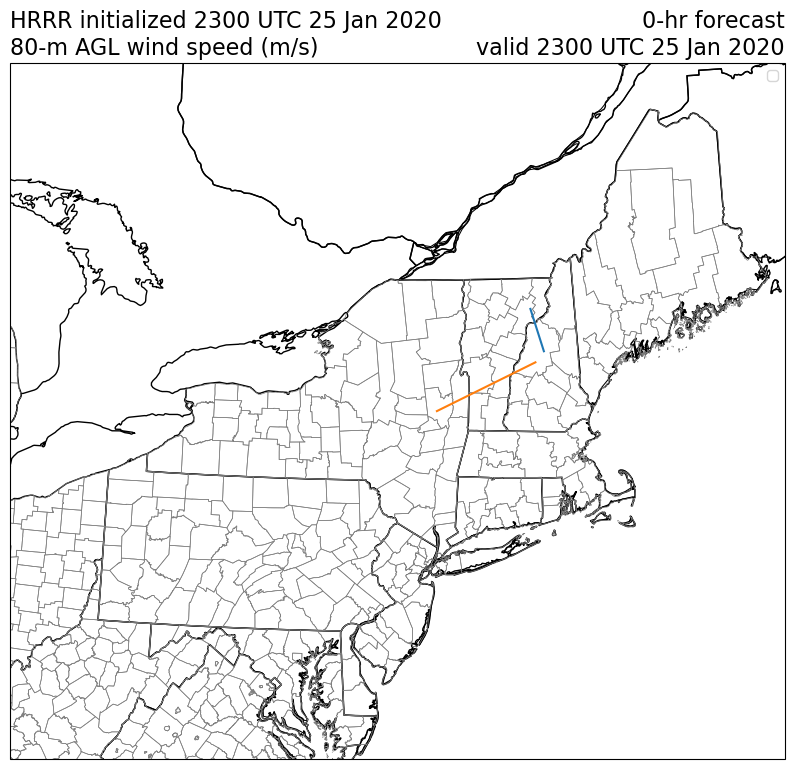

In [25]:
# Set Projection of Plot
fig = plt.figure(1,figsize=(10,8)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)
data_crs = data_gd['t'].metpy.cartopy_crs
ax.set_extent((lone+5, lonw, lats-5, latn))
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=1)
ax.add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.5, edgecolor='gray')
plt.title("HRRR initialized "+hrrr_init.strftime("%H%M UTC %d %b %Y")+"\n80-m AGL wind speed (m/s)",loc='left', fontsize=16)
plt.title(str(lead)+"-hr forecast\nvalid "+vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=16)
ax.legend()

cross_ls=[]
for n in range(len(fls)):
    if hrrr_init==hrrr_init_ls[n]:
        print('included',n)
        start=fls[n][0]
        end=fls[n][1]
        ft_df_fl=ft_df.between_time(start[11:], end[11:])

        lats=ft_df_fl['Lat'][0]
        late=ft_df_fl['Lat'][-1]
        lons=ft_df_fl['Lon'][0]
        lone=ft_df_fl['Lon'][-1]

        start_pt = (lats, lons)
        end_pt = (late, lone)
        fldistance=np.round(great_circle([lats, late], [lons, lone])/1000)+1

        if fl_choice=='ER2':
            steps=fldistance # for every 1 km along ER2
        if fl_choice=='P3':
            steps=ft_df_fl.shape[0] # for each point along P3 track
            
        cross = cross_section(data_gd, start_pt, end_pt, steps= steps).set_coords(('latitude', 'longitude'))
        cross['longitude'] = cross.longitude - 360.
        cross['longitude2d'] = cross.longitude.expand_dims({'hybrid':50})
        cross['latitude2d'] = cross.latitude.expand_dims({'hybrid':50})

        # Plot Location
        ax.plot(cross['longitude'], cross['latitude'], zorder=10,label='er2 HRRR CS', transform=ccrs.PlateCarree())

        # Calculating RH wrt water and ice, E wrt water and ice, Es wrt water and ice, and temperature at LCL
        t_cp=pd.DataFrame(cross.t.values-273.15)
        t_cp.iloc[np.where(t_cp<-50)]=np.NaN
        t_cp.iloc[np.where(t_cp>50)]=np.NaN
        
        rh_rhi_ls=np.ones(t_cp.shape)*np.NaN
        e_ei_arr=np.ones(t_cp.shape)*np.NaN
        es_esi_arr=np.ones(t_cp.shape)*np.NaN
        for j in range(t_cp.shape[0]):
            for k in range(t_cp.shape[1]):
                if t_cp.values[j,k]<=0:
                    esi=vpi_eqn(t_cp.values[j,k])
                    ei=vpi_eqn(cross.dpt.values[j,k])
                    rh_rhi_ls[j,k]=(ei/esi)*100
                    e_ei_arr[j,k]=ei
                    es_esi_arr[j,k]=esi
                if t_cp.values[j,k]>0:
                    es=vp_eqn(t_cp.values[j,k])
                    e=vp_eqn(cross.dpt.values[j,k])
                    rh_rhi_ls[j,k]=(e/es)*100
                    e_ei_arr[j,k]=e
                    es_esi_arr[j,k]=es
        cross['rh_rhi']=(("hybrid", "index"),rh_rhi_ls)
        cross['e_ei']=(("hybrid", "index"),e_ei_arr)
        cross['es_esi']=(("hybrid", "index"),es_esi_arr)
        cross['T_lcl']=(("hybrid", "index"),Tlcl(cross.t.values, cross.dpt.values+273.15))

        # Calculating Thetaei
        thetaei_empty=np.ones(cross.t.shape)*np.NaN
        thetaei=calc_thetaei(cross, thetaei_empty)
        cross['thetaei']=(("hybrid", "index"),thetaei)
        cross_ls.append(cross)

included 9 0


/tmp/ipykernel_42161/2842275814.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')
/tmp/ipykernel_42161/2842275814.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')


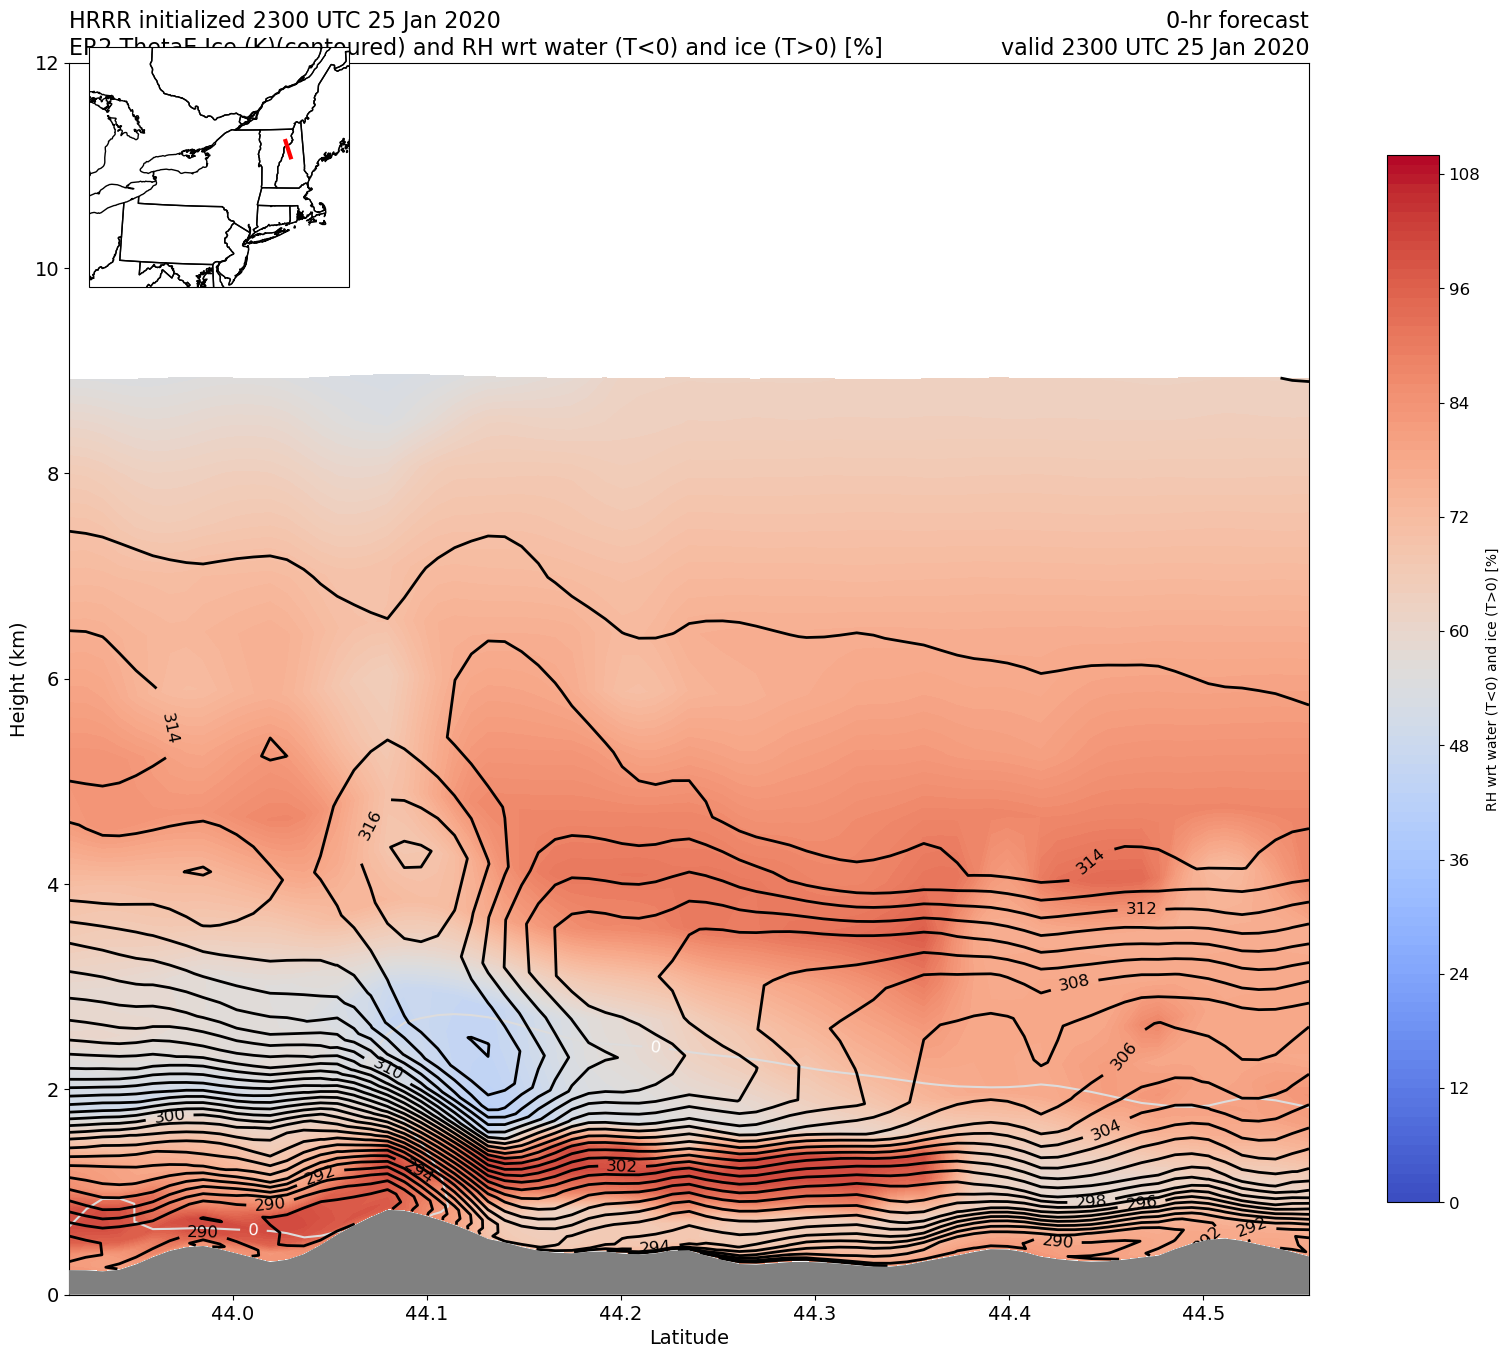

/tmp/ipykernel_42161/2842275814.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')
/tmp/ipykernel_42161/2842275814.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')


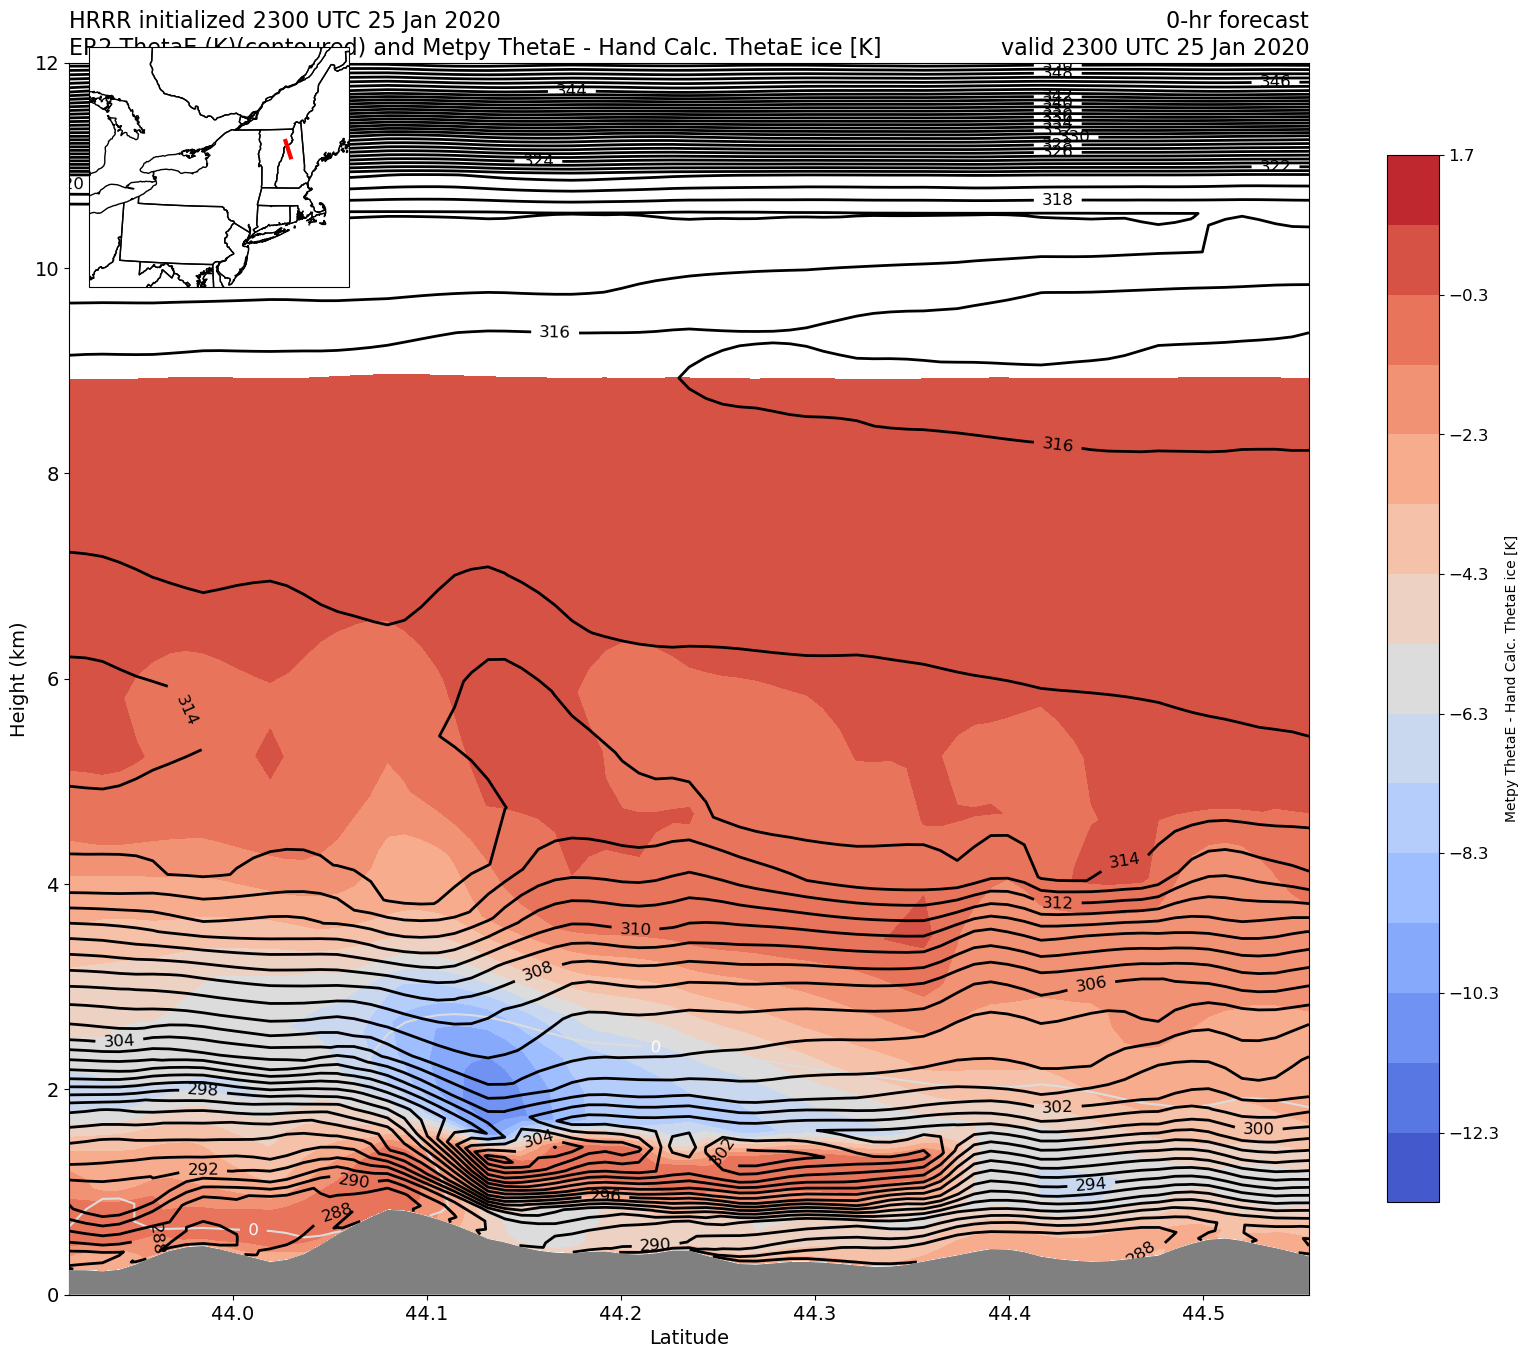

/tmp/ipykernel_42161/2842275814.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')
/tmp/ipykernel_42161/2842275814.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')


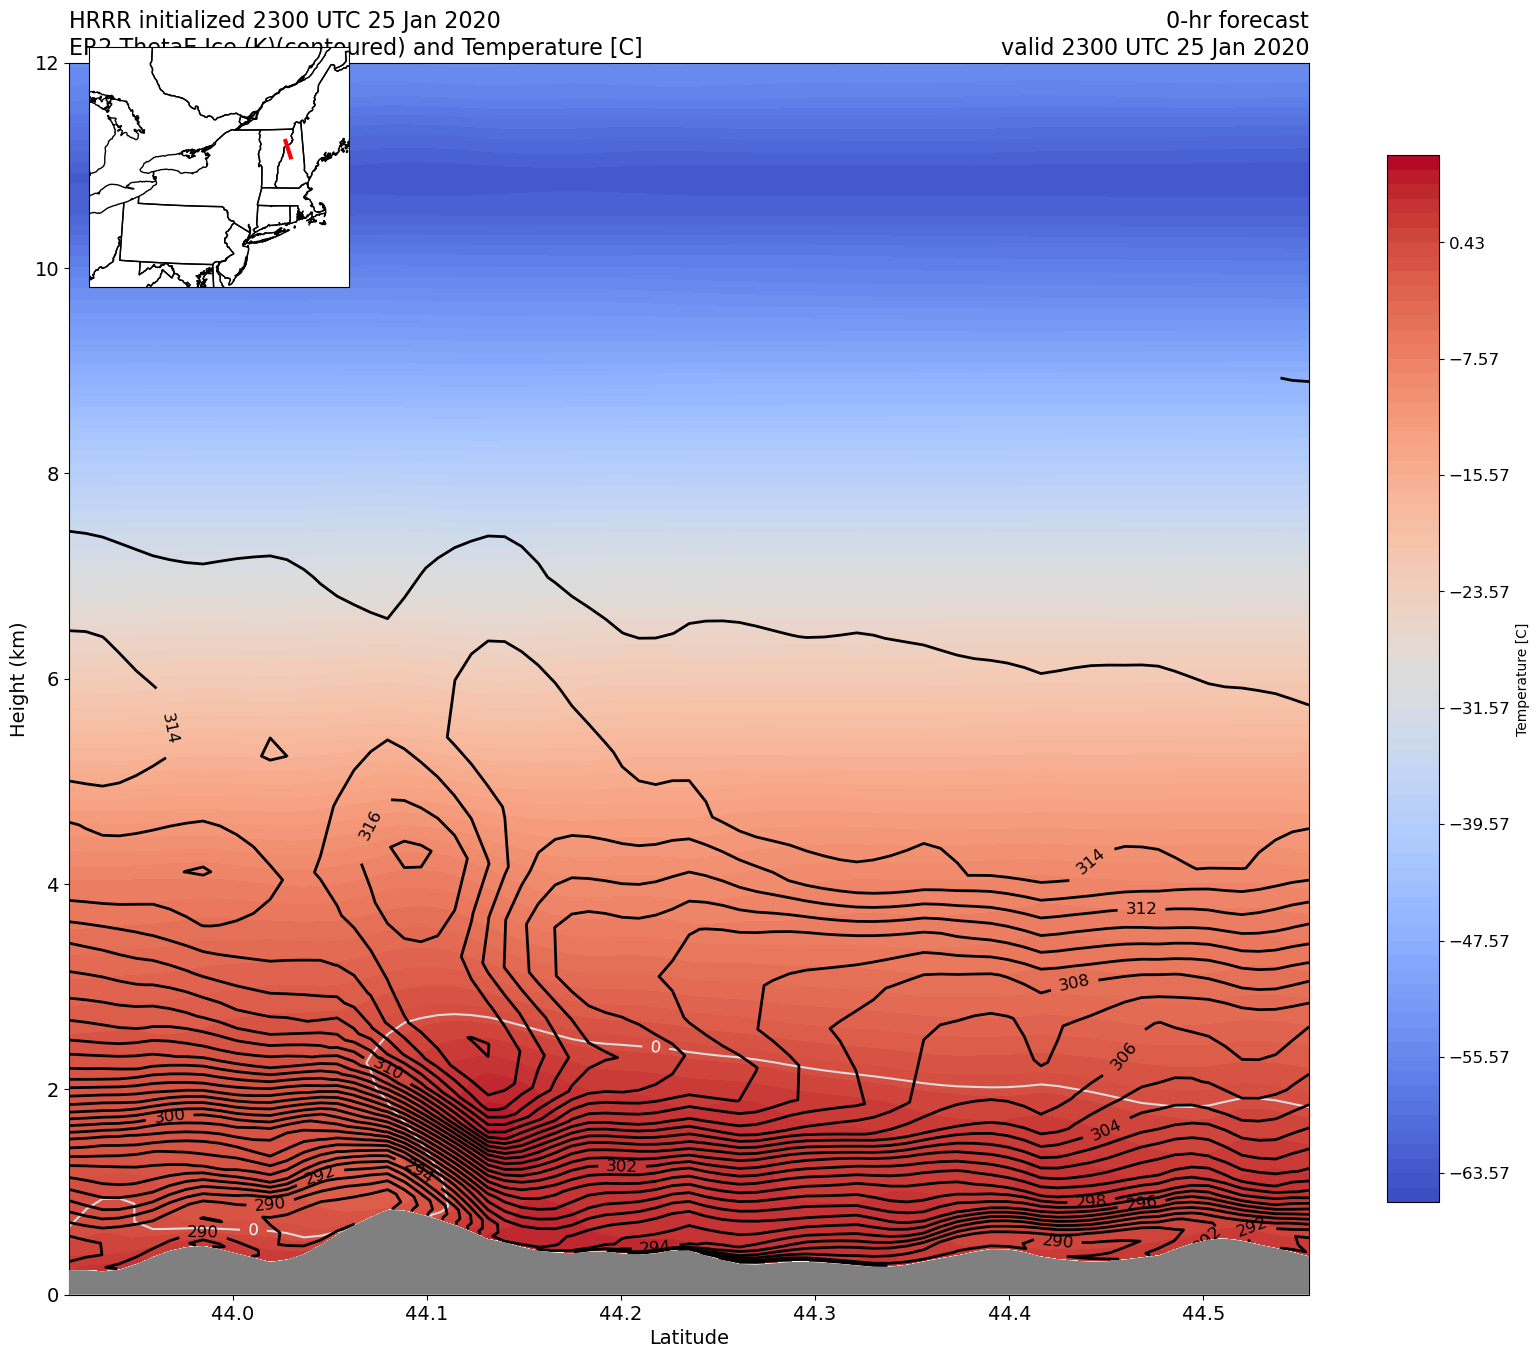

included 10 1


/tmp/ipykernel_42161/2842275814.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')
/tmp/ipykernel_42161/2842275814.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')


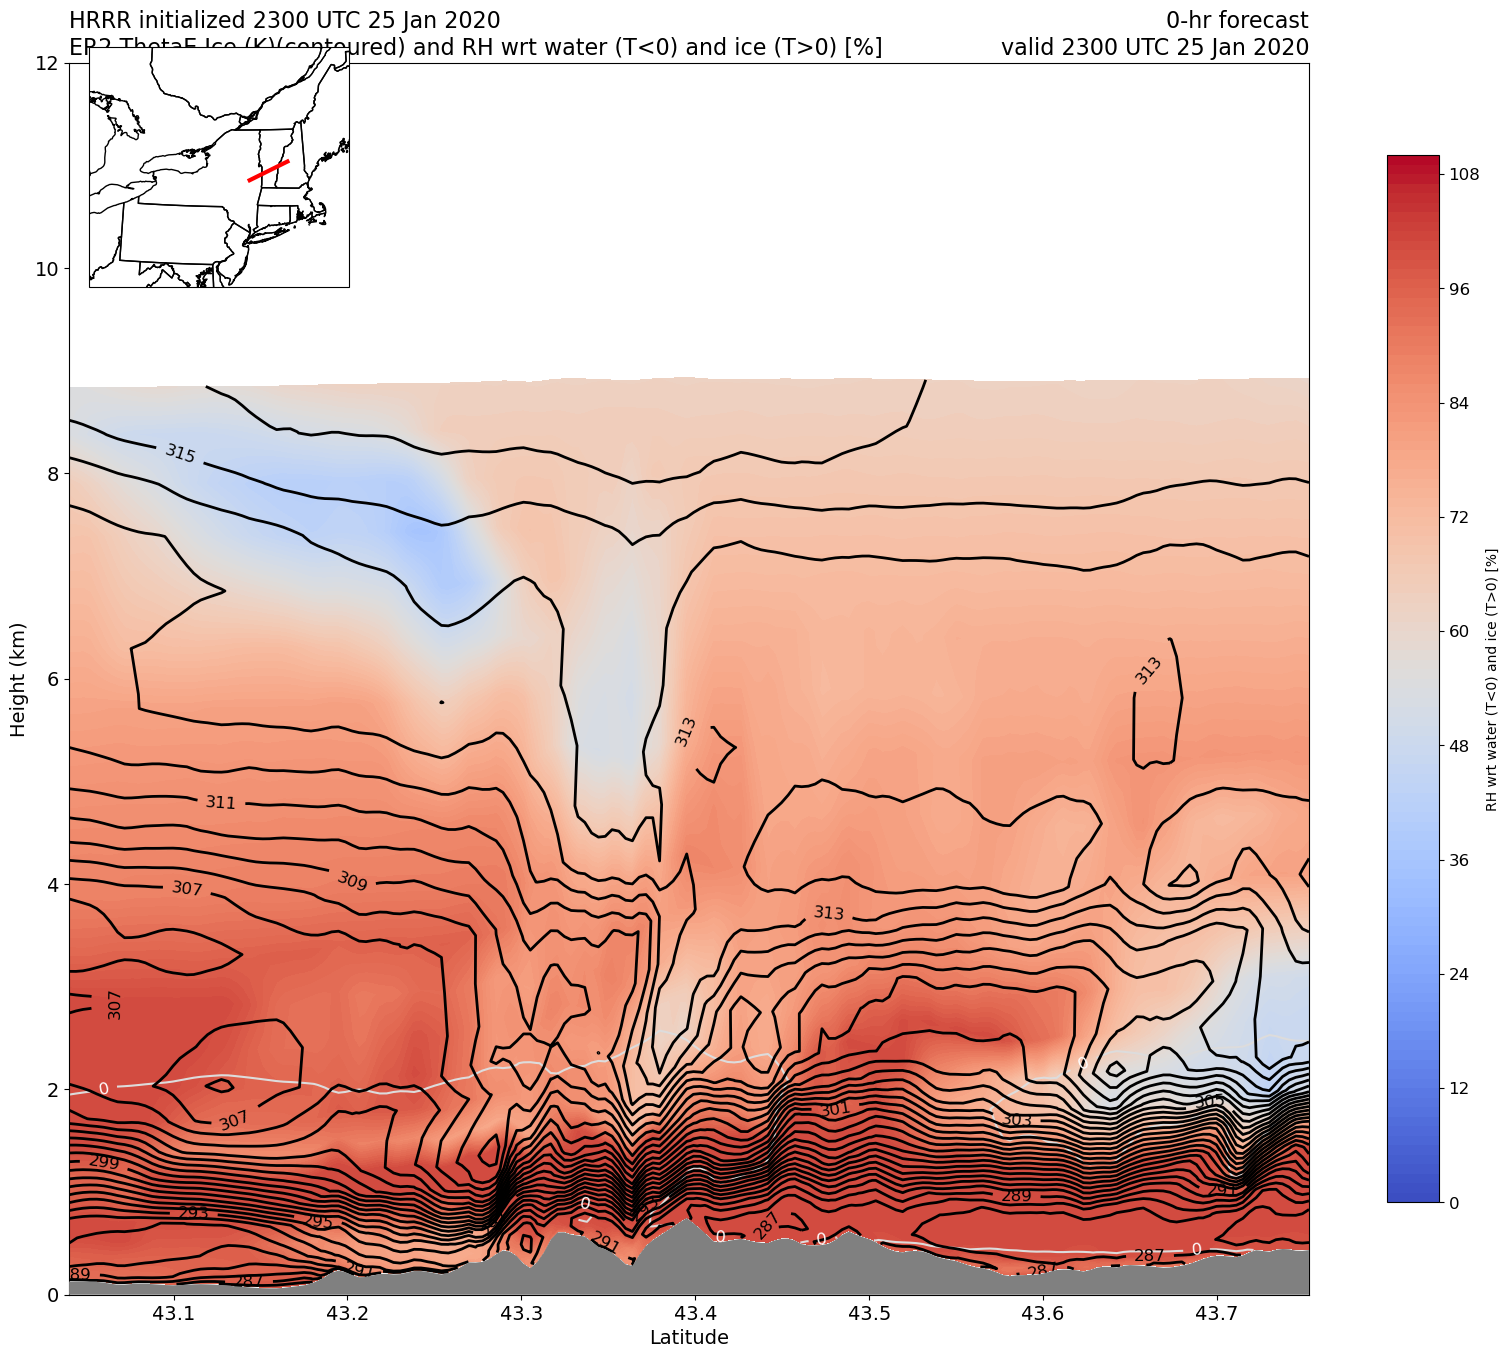

/tmp/ipykernel_42161/2842275814.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')
/tmp/ipykernel_42161/2842275814.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')


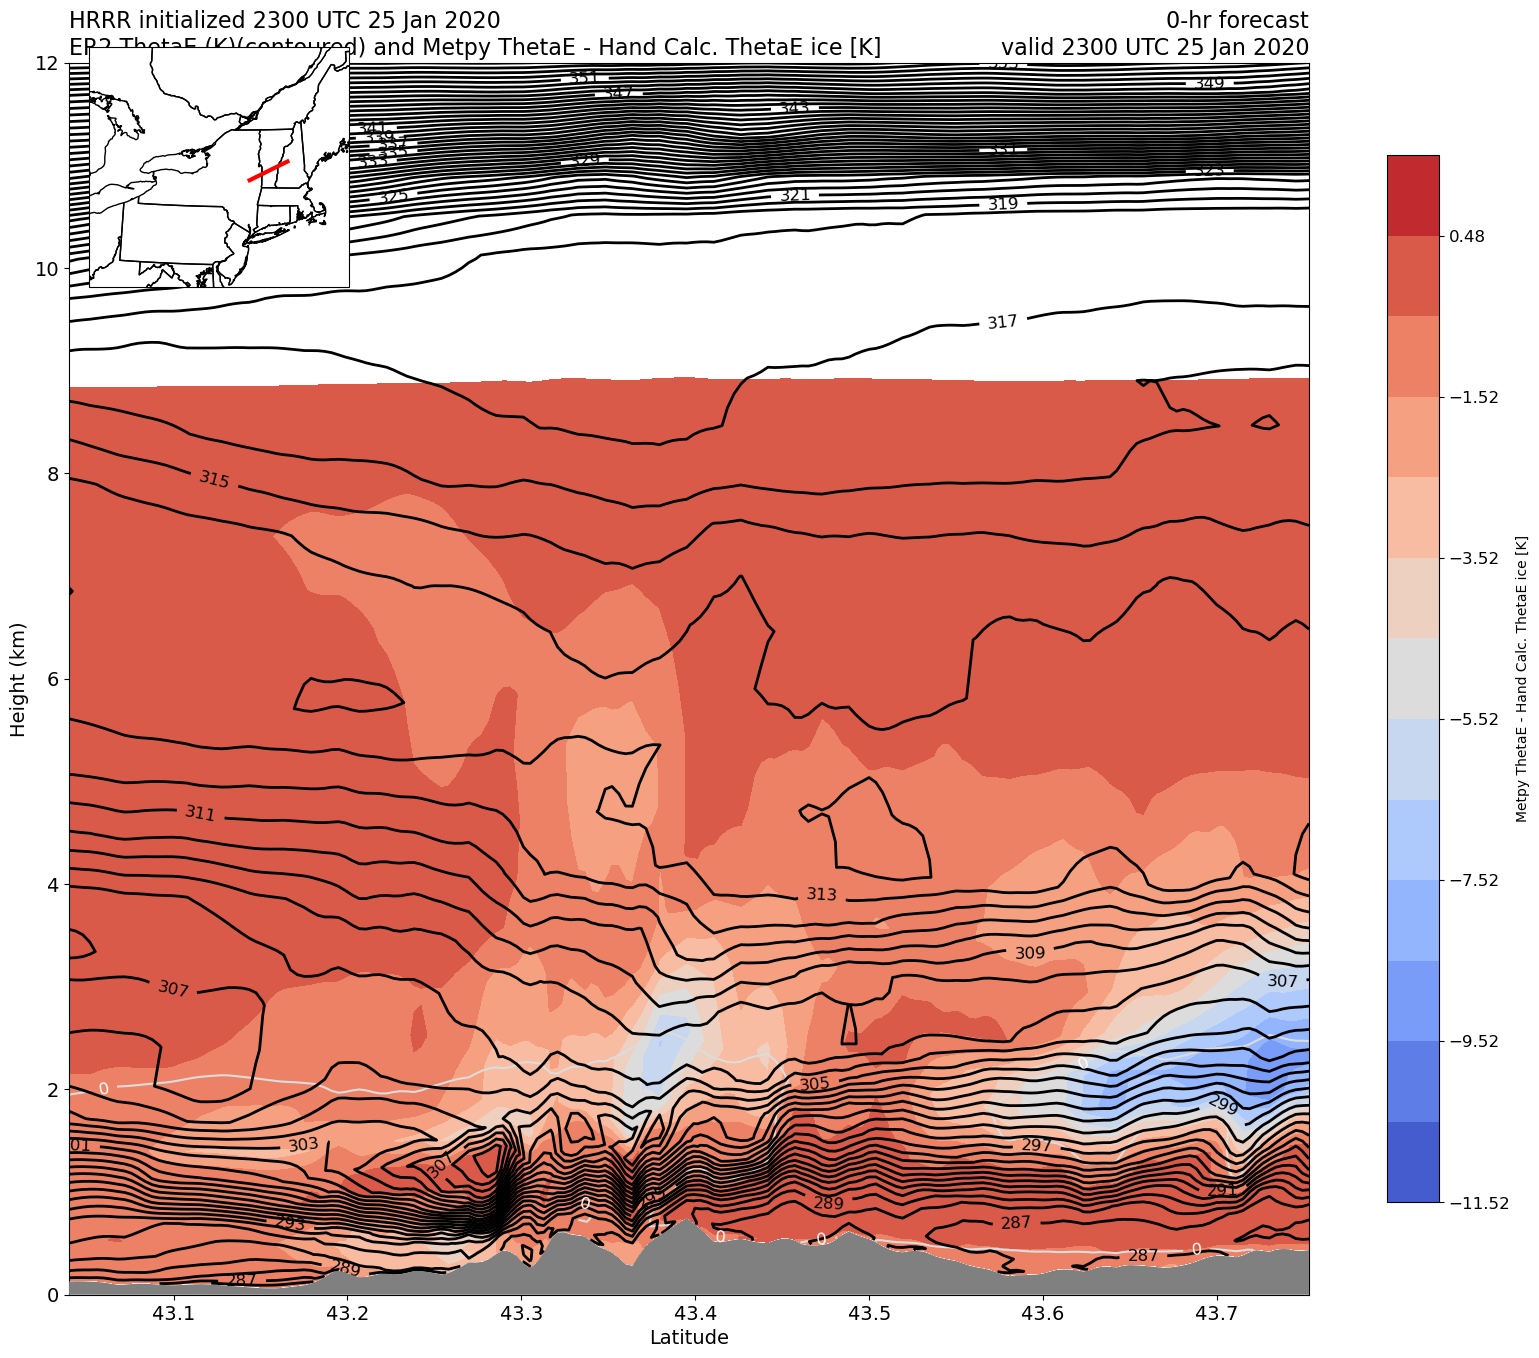

/tmp/ipykernel_42161/2842275814.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')
/tmp/ipykernel_42161/2842275814.py:13: UserWarning: The following kwargs were not used by contour: 'label'
  therm_0= ax.contour(cross['latitude2d'], cross['gh']/1000, cross['t']-273.15, levels= 0,cmap=get_cmap("coolwarm"), extend='max', label='0 C Isotherm')


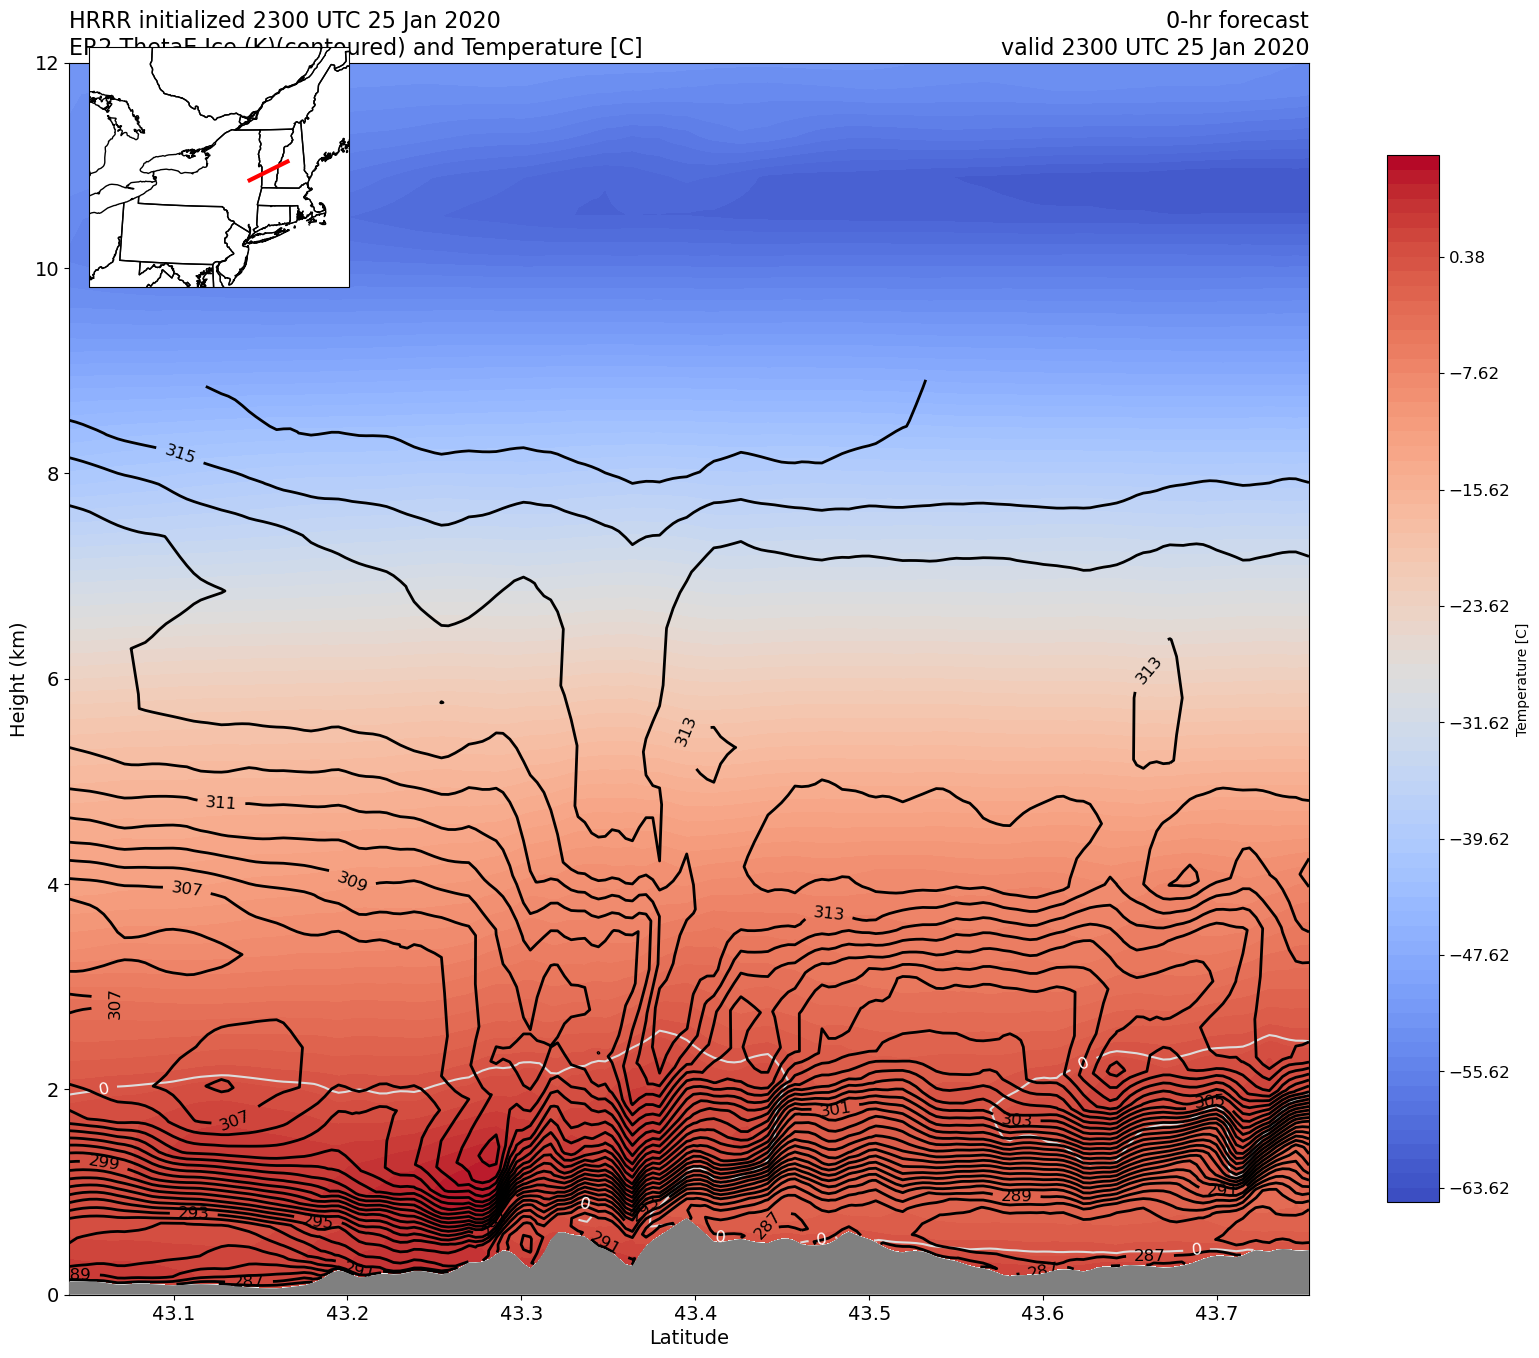

In [26]:
count=0
for n in range(len(fls)):
    if hrrr_init==hrrr_init_ls[n]:
        print('included',n, count)
        start=fls[n][0]
        end=fls[n][1]
        ft_df_fl=ft_df.between_time(start[11:], end[11:])
        hrrr_cs(ft_df_fl,cross_ls[count], cross_ls[count]['rh_rhi'], cross_ls[count]['thetaei'], 'RH wrt water (T<0) and ice (T>0) [%]', fl_choice+' ThetaE Ice (K)', cmap="coolwarm", 
                levels_cf=np.arange(0,111,1),levels_c=np.arange(np.nanmin(cross_ls[count]['thetaei'])-1, np.nanmax(cross_ls[count]['thetaei'])+1, 1))
        hrrr_cs(ft_df_fl, cross_ls[count], cross_ls[count]['thetae'].values-cross_ls[count]['thetaei'].values, cross_ls[count]['thetae'], 'Metpy ThetaE - Hand Calc. ThetaE ice [K]', fl_choice+' ThetaE (K)', cmap="coolwarm", 
                levels_cf=np.arange(np.nanmin(cross_ls[count]['thetae'].values-cross_ls[count]['thetaei'].values)-2,np.nanmax(cross_ls[count]['thetae'].values-cross_ls[count]['thetaei'].values)+2,1),
                levels_c=np.arange(np.nanmin(cross_ls[count]['thetae'])-1, np.nanmax(cross_ls[count]['thetae'])+1, 1))
        hrrr_cs(ft_df_fl, cross_ls[count], cross_ls[count]['t'].values-273.15, cross_ls[count]['thetaei'], 'Temperature [C]', fl_choice+' ThetaE Ice (K)', cmap="coolwarm", 
                levels_cf=np.arange(np.nanmin(cross_ls[count]['t'].values-273.15)-2,np.nanmax(cross_ls[count]['t'].values-273.15)+2,1),levels_c=np.arange(np.nanmin(cross_ls[count]['thetaei'])-1, np.nanmax(cross_ls[count]['thetaei'])+1, 1))
        count=count+1

# Saving Cross Section

In [27]:
count=0
for n in range(len(fls)):
    if hrrr_init==hrrr_init_ls[n]:
        flnum=fls[n][2]
        cross=cross_ls[count].drop('metpy_crs')
        #cross=cross.expand_dims(dim="time")
        if fl_choice=='P3':
            cross.to_netcdf(path+'HRRR_FLCS/hrrr_cross'+fl_choice+'_'+day+'_fl'+flnum+'.nc')
        if fl_choice=='ER2':
            cross.to_netcdf(path+'HRRR_FLCS/hrrr_cross'+fl_choice+'_'+day+'_fl'+flnum+'.nc')
        count=count+1

/tmp/ipykernel_42161/1867331801.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  cross=cross_ls[count].drop('metpy_crs')
/tmp/ipykernel_42161/1867331801.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  cross=cross_ls[count].drop('metpy_crs')
